# Handwriting & Digit Recognition

## Assignment 1

Taken from Udacity's Deep Learning online course:

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. 

This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile

from collections import Counter
from IPython.display import display, Image
from scipy import ndimage
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## Sample of the letter 'A'

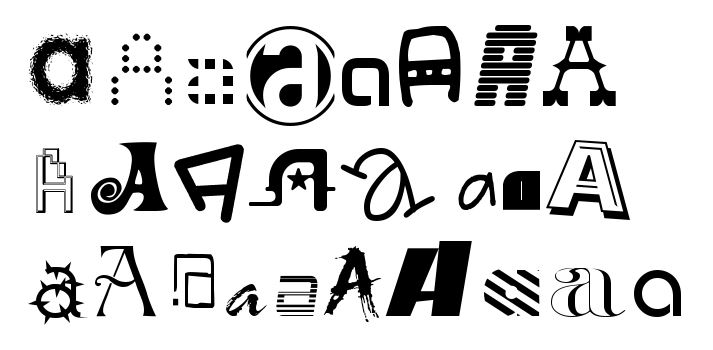

In [2]:
Image(r'C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST.jpg', format= 'jpg')

## Download Files

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    '''A hook to report the progress of a download. This is mostly intended for users with 
    slow internet connections. Reports every 5% change in download progress.
    '''
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

# Comment these back in to download files
#train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
#test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

train_filename = os.path.join(os.getcwd(), 'data', 'notMNIST_large.tar.gz')
test_filename = os.path.join(os.getcwd(), 'data', 'notMNIST_small.tar.gz')

## Extract Dataset

Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
        
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
    
        if os.path.isdir(os.path.join(root, d))]
    
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

# Comment these in to attempt the zip extract
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large already present - Skipping extraction of C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large.tar.gz.
['C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\A', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\B', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\C', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\D', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\E', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\F', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\G', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\\notMNIST_large\\H', 'C:\\Dev\\Python\\Virtualenvs\\python27\\Dev\\Udacity\\notMNIST\\data\

## Problem 1

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [5]:
img_name = r'ZXVyb2Z1cmVuY2UgYm9sZGl0YWxpYy50dGY=.png'

img = Image(os.path.join(os.getcwd(), 'data', 'notMNIST_large', 'B', img_name), 
            format= 'png')

img

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)

    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
        
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\A.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\B.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\C.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\D.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\E.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\F.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\G.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenvs\python27\Dev\Udacity\notMNIST\data\notMNIST_large\H.pickle already present - Skipping pickling.
C:\Dev\Python\Virtualenv

## Problem 2

Verify that the images are still nice and pretty

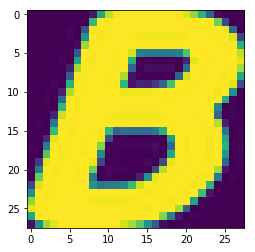

In [7]:
with open(train_datasets[1], 'rb') as fp:
    letter_set = pickle.load(fp)
    plt.imshow(letter_set[-1])

## Problem 3

Make sure each class has balanced observations

In [8]:
for i in range(10):
    with open(train_datasets[i], 'rb') as fp:
        letter_set = pickle.load(fp)
        print(letter_set.shape)

(52909L, 28L, 28L)
(52911L, 28L, 28L)
(52912L, 28L, 28L)
(52911L, 28L, 28L)
(52912L, 28L, 28L)
(52912L, 28L, 28L)
(52912L, 28L, 28L)
(52912L, 28L, 28L)
(52912L, 28L, 28L)
(52911L, 28L, 28L)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # Let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable t process data from', pickle_file, ':', e)
            raise
            
    return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000  #400000
valid_size = 10000   #18000
test_size = 10000    #18000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000L, 28L, 28L) (200000L,)
Validation: (10000L, 28L, 28L) (10000L,)
Testing: (10000L, 28L, 28L) (10000L,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    
    return shuffled_dataset, shuffled_labels


train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4

Convince yourself that the data is still good after shuffling.

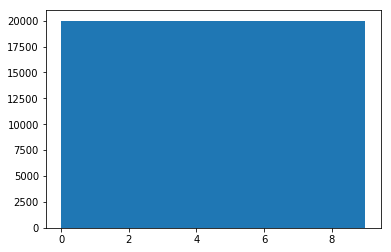

In [11]:
plt.hist(train_labels)
plt.show()

In [12]:
Counter(train_labels), Counter(test_labels)

(Counter({0: 20000,
          1: 20000,
          2: 20000,
          3: 20000,
          4: 20000,
          5: 20000,
          6: 20000,
          7: 20000,
          8: 20000,
          9: 20000}),
 Counter({0: 1000,
          1: 1000,
          2: 1000,
          3: 1000,
          4: 1000,
          5: 1000,
          6: 1000,
          7: 1000,
          8: 1000,
          9: 1000}))

Finally, let's save the data for later reuse

In [13]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [14]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800451


## Problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:
  * What about near duplicates between datasets? (images that are almost identical)
  * Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [15]:
train_dataset.flags.writeable=False
test_dataset.flags.writeable=False

dup_table={}

num_dups1=0
for idx,img in enumerate(train_dataset):
    h = hash(img.data)
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
        #print('Duplicate image: %d matches %d' % (idx, dup_table[h]))
        num_dups1 += 1
    dup_table[h] = idx

num_dups2=0
for idx,img in enumerate(test_dataset):
    h = hash(img.data)
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
        #print('Test image %d is in the training set' % idx)
        num_dups2 += 1

print('Number of duplicate images in training set', num_dups1)
print('Number of Test images in the Training set', num_dups2)

Number of duplicate images in training set 12783
Number of Test images in the Training set 1324


## Problem 6

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: 

  * Train an off-the-shelf model on all the data!

In [16]:
train_dataset[:5]

array([[[-0.5       , -0.49607843, -0.5       , ..., -0.5       ,
         -0.49215686, -0.5       ],
        [-0.49607843, -0.47647059, -0.5       , ..., -0.5       ,
         -0.47254902, -0.49607843],
        [-0.49607843, -0.49607843, -0.5       , ..., -0.5       ,
         -0.49607843, -0.49607843],
        ..., 
        [-0.49607843, -0.49215686, -0.5       , ..., -0.5       ,
         -0.49215686, -0.49607843],
        [-0.49607843, -0.47647059, -0.5       , ..., -0.5       ,
         -0.47254902, -0.49607843],
        [-0.5       , -0.49607843, -0.5       , ..., -0.5       ,
         -0.49607843, -0.5       ]],

       [[-0.5       , -0.5       , -0.5       , ...,  0.48823529,
          0.5       ,  0.1509804 ],
        [-0.5       , -0.5       , -0.5       , ...,  0.48431373,
          0.14705883, -0.32745099],
        [-0.5       , -0.5       , -0.5       , ..., -0.32745099,
         -0.5       , -0.49607843],
        ..., 
        [-0.5       , -0.44901961,  0.1509804 , ...,

In [17]:
train_labels[:5]

array([4, 9, 6, 2, 7])

In [26]:
train_samples, train_width, train_height = train_dataset.shape
test_samples, test_width, test_height = test_dataset.shape

num_samples = 10000

In [27]:
train_dataset.shape

(200000L, 28L, 28L)

In [28]:
X = np.reshape(train_dataset, (train_samples, train_width * train_height))[0:num_samples]
y = train_labels[:num_samples]

X_test = np.reshape(test_dataset, (test_samples, test_width * test_height))[0:num_samples]
y_test = test_labels[:num_samples]

In [29]:
X[:5]

array([[-0.5       , -0.49607843, -0.5       , ..., -0.5       ,
        -0.49607843, -0.5       ],
       [-0.5       , -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , ..., -0.48823529,
        -0.5       , -0.5       ],
       [-0.5       , -0.49607843, -0.49607843, ..., -0.5       ,
        -0.5       , -0.5       ]], dtype=float32)

In [30]:
y[:5]

array([4, 9, 6, 2, 7])

In [31]:
clf_model = linear_model.LogisticRegression(
    penalty='l2', 
    dual=False, 
    tol=0.0001, 
    C=1.0, 
    fit_intercept= True,
    solver= 'liblinear',
    max_iter=100,
)

In [32]:
clf_model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
print('model validation score', clf_model.score(X_test, y_test))

model validation score 0.8596
